In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
data = pd.read_csv('simulacionesFull1.csv')

In [68]:
print(data.shape)
data.head()

(1133000, 12)


,Identificador,Numero_agentes,Tipo_red,Agente,Ronda,Estado,Puntaje,Politica,Parametro-0,Parametro-1,Politica_lag,Consistencia
0,0,5,Full,0,0,0,0,7,5,1,NaN,NaN
1,0,5,Full,0,10,1,-1,7,5,1,7.0,1.0
2,0,5,Full,0,20,1,-1,7,5,1,7.0,1.0
3,0,5,Full,0,30,1,-1,7,5,1,7.0,1.0
4,0,5,Full,0,40,1,-1,7,5,1,7.0,1.0


In [69]:
data_full = data.query('Tipo_red=="Full"').copy()

In [70]:
data_full.Numero_agentes.unique()

array([   5,    6,   10,   11,  101, 1000], dtype=int64)

In [71]:
experimentos = data_full.groupby('Numero_agentes')['Identificador'].unique()
experimentos = experimentos.apply(len)
experimentos

Numero_agentes
5       100
6       100
10      100
11      100
101     100
1000    100
Name: Identificador, dtype: int64

Medida de asistencia óptima al bar El Farol:

Es un número entre 0 y 1, donde 1 significa que en todas las rondas, la asistencia al bar fue de 0.5; 0 significa que o bien la asistencia en todas las rondas fue 0 o 1.

$$ 1 - 2*\sqrt{\frac{\sum_{r}(Asistencia_{r} - 0.5)^2}{R}}$$

In [72]:
aux = data_full.groupby(['Numero_agentes', 'Identificador', 'Ronda'])['Estado']\
    .sum().reset_index()
aux.columns = ['Numero_agentes',
               'Identificador',
               'Ronda', 
               'Asistencia_total']

# Proporción de asistencia
aux['Asistencia'] = aux['Asistencia_total']/aux['Numero_agentes']
# Distancia al cuadrado entre proporción de asistencia y 0.5
aux['diferencia_con_umbral'] = (aux['Asistencia'] - 0.5)*(aux['Asistencia'] - 0.5)
aux.head()

,Numero_agentes,Identificador,Ronda,Asistencia_total,Asistencia,diferencia_con_umbral
0,5,0,0,1,0.2,0.09
1,5,0,10,5,1.0,0.25
2,5,0,20,5,1.0,0.25
3,5,0,30,5,1.0,0.25
4,5,0,40,5,1.0,0.25


In [73]:
num_rondas = aux.Ronda.max() + 1
num_rondas

91

In [74]:
df = aux.groupby(['Numero_agentes', 'Identificador'])['diferencia_con_umbral'].sum().reset_index()
df['Asistencia_optima'] = df['diferencia_con_umbral']/num_rondas
df['Asistencia_optima'] = 1 - 2 * np.sqrt(df['Asistencia_optima'])
df.head()

,Numero_agentes,Identificador,diferencia_con_umbral,Asistencia_optima
0,5,0,2.34,0.679287
1,5,1,2.26,0.684816
2,5,2,2.34,0.679287
3,5,3,0.10,0.933701
4,5,4,2.34,0.679287


In [75]:
df['Asistencia_optima'].describe()

count    600.000000
mean       0.773979
std        0.114416
min        0.668503
25%        0.684816
50%        0.685513
75%        0.889501
max        1.000000
Name: Asistencia_optima, dtype: float64

(0, 1)

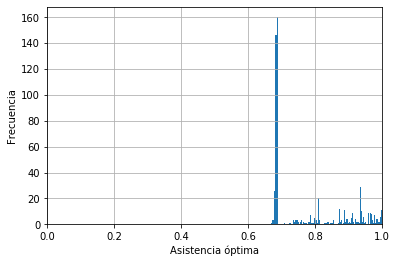

In [78]:
df['Asistencia_optima'].hist(bins = 100)
plt.xlabel('Asistencia óptima')
plt.ylabel('Frecuencia')
plt.xlim([0,1])

Text(0, 0.5, 'Promedio asistencia óptima\nsobre 100 simulaciones')

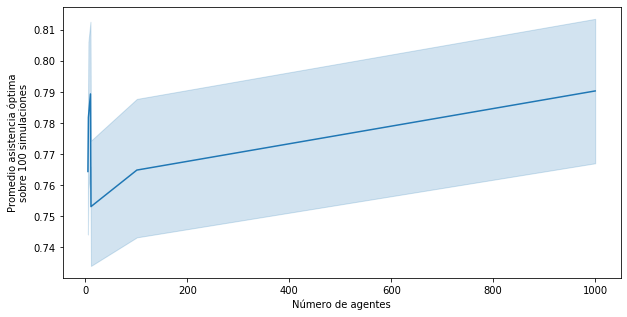

In [79]:
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Numero_agentes'], y=df['Asistencia_optima'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio asistencia óptima\nsobre 100 simulaciones')

Medida de recompensa total:

$$\frac{\sum_{a, r} recompensa(a, r)}{A*R}$$

In [81]:
data_recomp = data.groupby(['Numero_agentes', 'Identificador'])["Puntaje"].sum().reset_index()
data_recomp["Puntaje promedio"]=data_recomp["Puntaje"]/(num_rondas*data_recomp["Numero_agentes"])
data_recomp


,Numero_agentes,Identificador,Puntaje,Puntaje promedio
0,5,0,-44,-0.096703
1,5,1,-48,-0.105495
2,5,2,1,0.002198
3,5,3,15,0.032967
4,5,4,-44,-0.096703
...,...,...,...,...
595,1000,595,2432,0.026725
596,1000,596,470,0.005165
597,1000,597,-4244,-0.046637
598,1000,598,-9523,-0.104648


Text(0, 0.5, 'Promedio puntaje \nsobre 100 simulaciones')

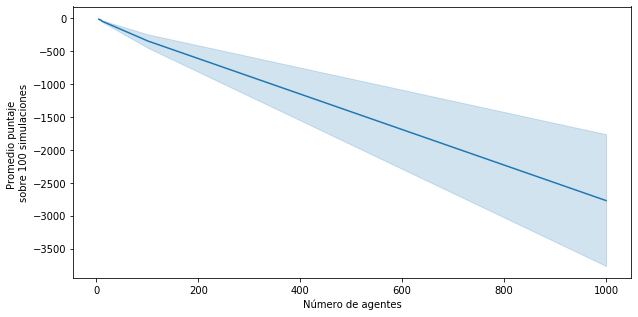

In [82]:
fig = plt.subplots(figsize=(10,5))
sns.lineplot(x=data_recomp['Numero_agentes'], y=data_recomp['Puntaje'])
plt.xlabel('Número de agentes')
plt.ylabel('Promedio puntaje \nsobre 100 simulaciones')

Medida de equidad en al distribución de recursos:

Índice de Gini:
$X_{j}$ : Puntaje acumulado del agente $j$  
$$N+1-2\frac{\sum_{i=1}^N\sum_{j=1}^i X_{j}}{\sum_{k=1}^N X_{k}}$$

In [83]:
def gini(x):
        # The rest of the code requires numpy arrays.
        x = np.asarray(x) #convierte x en un vector
        sorted_x = np.sort(x) #los organiza de menor a mayor
        n = len(x) #tamaño del vector x
        cumx = np.cumsum(sorted_x, dtype=float)# va haciendo la suma acumulativa
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n #esta es una formula muy rara, esta en alternate expression de Wikipedia
        pe_line = np.linspace(start=0.0, stop=1.0, num=len(cumx))
        area_under_lorenz = np.trapz(y=cumx, dx=1/len(cumx)) #area de la suma acumulada, zona azul
        area_under_pe = np.trapz(y=pe_line, dx=1/len(cumx)) #area de la linea perfecta, caso perfecto
        cumx=cumx/cumx[-1] #normalizando para que se vea en la grafica bien
        # The above formula, with all weights equal to 1 simplifies to:
        return gini, pe_line,area_under_lorenz,area_under_pe,cumx

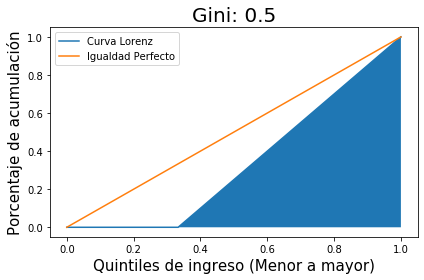

In [84]:
gini, pe_line,area_under_lorenz,area_under_pe,cumx = gini([1,1,0,0])
from matplotlib import pyplot as plt

plt.plot(pe_line, cumx, label='Curva Lorenz')
plt.plot(pe_line, pe_line, label='Igualdad Perfecto')
plt.fill_between(pe_line, cumx)
plt.title('Gini: {}'.format(gini), fontsize=20)
plt.ylabel('Porcentaje de acumulación', fontsize=15)
plt.xlabel('Quintiles de ingreso (Menor a mayor)', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
def gini1(x):
    x = np.asarray(x) 
    sorted_x = np.sort(x) 
    n = len(x) 
    cumx = np.cumsum(sorted_x, dtype=float)
    try:
        gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    except:
        gini = 1
    return np.round(gini,3)

In [86]:
data_aux = data.copy()
data_aux['Puntaje normalizado'] = data_aux['Puntaje'] + 1
data_aux = data_aux.groupby(['Numero_agentes', 'Identificador', 'Agente'])['Puntaje normalizado'].sum().reset_index()
data_aux.head()

,Numero_agentes,Identificador,Agente,Puntaje normalizado
0,5,0,0,1
1,5,0,1,1
2,5,0,2,2
3,5,0,3,1
4,5,0,4,1


In [87]:
data_aux['Gini'] = data_aux.groupby(['Numero_agentes','Identificador'])['Puntaje normalizado'].transform(func = gini1)
data_aux

,Numero_agentes,Identificador,Agente,Puntaje normalizado,Gini
0,5,0,0,1,0.133
1,5,0,1,1,0.133
2,5,0,2,2,0.133
3,5,0,3,1,0.133
4,5,0,4,1,0.133
...,...,...,...,...,...
113295,1000,599,995,10,0.161
113296,1000,599,996,10,0.161
113297,1000,599,997,18,0.161
113298,1000,599,998,10,0.161


In [88]:
data_gini = data_aux.groupby(['Numero_agentes', 'Identificador']).agg({'Gini':'first'}).reset_index()
data_gini.shape

(600, 3)

In [89]:
data_gini['Gini'].isna().value_counts()

False    600
Name: Gini, dtype: int64

In [ ]:
#fig = plt.subplots(figsize = (10,4))
#sns.countplot(x = 'Gini', hue = 'Numero_agentes', data = data_gini)
#plt.xticks(np.arange(0, 0.25, 1))
#plt.xlim([0, 1])
g = sns.FacetGrid(data_gini, col='Gini',  row='Numero_agentes')
g = g.map(sns.distplot, 'Gini', kde=True)


C:\Users\juanl\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\juanl\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\juanl\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\juanl\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\juanl\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\juanl\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data

Links:

* https://stackoverflow.com/questions/31416664/python-gini-coefficient-calculation-using-numpy?noredirect=1&lq=1
* https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python?noredirect=1&lq=1